In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
import scipy
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
import warnings
from sklearn.model_selection import train_test_split, KFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import random
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score


Bad key text.latex.preview in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [2]:
warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv('./data/APT_data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Floor                            100000 non-null  float64
 1   Building_Age                     100000 non-null  int64  
 2   JS_BA                            100000 non-null  float64
 3   Population                       100000 non-null  int64  
 4   IR                               100000 non-null  float64
 5   LC_index                         100000 non-null  float64
 6   CA_index                         100000 non-null  float64
 7   TC_index                         100000 non-null  float64
 8   SDT_index                        100000 non-null  float64
 9   Crime_Rates                      100000 non-null  float64
 10  latitude                         100000 non-null  float64
 11  longitude                        100000 non-null  float64
 12  Sel

## Categorical:

- Nominal(variables that have two or more categories, but which do not have an intrinsic order.)

    - Region_Name_y : 자치구 명
    - Building_Use_y : 건물 용도
    
- Ordinal(variables that have two or more categories just like nominal variables. Only the categories can also be ordered or ranked.)

    
## Numeric:

- Discrete
    - YearMonth : 년월
    - Building_Age : 건물연식
    - JS_Price : 전세가
   
- Continous
    - Sell_Price : 매매 가격
    - JS_BA = JS_Building Area : 임대 면적
    - lR = Interest Rate : 금리
    - UR = Unemployment Rate : 실업률
    - LC_index = Leading Composite index : 선행종합 지수
    - CA_index = Comprehensive Accompany index : 동행종합 지수
    - TC_index = Trailing Composite index : 후행종합 지수
    - SDT_index = Supply and Demand Trend index = 전세수급동향 지수
    - HSP_index : 경기종합지수
    - Population : 인구수
    - Crime_Rates : 범죄율
    - Shortest_Distance_to_Subway : 가장 가까운 지하철역과의 거리
    - Shortest_Distance_to_School : 가장 가까운 초중고등학교와의 거리
    - Shortest_Distance_to_Univ : 가장 가까운 대학교와의 거리
    

## 데이터 전처리

In [5]:
# 범주형 변수 리스트 지정
categorical_columns = ['Building_Use_y', 'Region_Name_y', 'YearMonth']
target_column = 'JS_Price'

# 데이터 분할: 학습용(train), 테스트용(test)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# 학습 데이터에서 검증용(validation) 데이터를 다시 분할
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# 각 범주형 변수에 대한 인코딩 매핑을 저장할 딕셔너리 초기화
encoding_maps = {}

# 학습 데이터에서 각 범주의 평균 타겟 값 계산 및 매핑 저장
for categorical_column in categorical_columns:
    encoding_map = train_data.groupby(categorical_column)[target_column].mean().to_dict()
    encoding_maps[categorical_column] = encoding_map

    # 학습 데이터에 타겟 인코딩 적용
    train_data[categorical_column + '_encoded'] = train_data[categorical_column].map(encoding_map)
    val_data[categorical_column + '_encoded'] = val_data[categorical_column].map(encoding_map)
    test_data[categorical_column + '_encoded'] = test_data[categorical_column].map(encoding_map)

    # 기존 범주형 변수 삭제
    train_data.drop(columns=[categorical_column], inplace=True)
    val_data.drop(columns=[categorical_column], inplace=True)
    test_data.drop(columns=[categorical_column], inplace=True)

In [6]:
# JS_Price를 4개의 범주로 나눔
train_data['JS_Price_Category'] = pd.cut(train_data['JS_Price'], bins=5, labels=False)
val_data['JS_Price_Category'] = pd.cut(val_data['JS_Price'], bins=5, labels=False)
test_data['JS_Price_Category'] = pd.cut(test_data['JS_Price'], bins=5, labels=False)

# 각 구간의 경계값을 구함
bin_edges = pd.cut(df['JS_Price'], bins=5).unique()

# 결과 출력
print("구간의 경계값:")
print(bin_edges)

# 기존 변수 삭제
train_data.drop('JS_Price', axis=1, inplace=True)
val_data.drop('JS_Price', axis=1, inplace=True)
test_data.drop('JS_Price', axis=1, inplace=True)

# 오버샘플링할 데이터와 레이블을 준비합니다.
X_train = train_data.drop('JS_Price_Category', axis=1)  # 독립변수
Y_train = train_data['JS_Price_Category']  # 종속변수
X_val = val_data.drop('JS_Price_Category', axis=1)  # 검증 독립변수
Y_val = val_data['JS_Price_Category']  # 검증 종속변수
X_test = test_data.drop('JS_Price_Category', axis=1)  # 테스트 독립변수
Y_test = test_data['JS_Price_Category']  # 테스트 종속변수

# RandomOverSampler를 초기화합니다.
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# 오버샘플링을 적용합니다(테스트 데이터는 일반화 성능 평가를 위해 적용X)
X_train_resampled, Y_train_resampled = oversampler.fit_resample(X_train, Y_train)

# 오버샘플링된 데이터를 새로운 데이터프레임으로 만듭니다.
train_data_resampled = pd.concat([X_train_resampled, Y_train_resampled], axis=1)

구간의 경계값:
[(128.633, 101506.4], (101506.4, 202379.8], (202379.8, 303253.2], (303253.2, 404126.6], (404126.6, 505000.0]]
Categories (5, interval[float64, right]): [(128.633, 101506.4] < (101506.4, 202379.8] < (202379.8, 303253.2] < (303253.2, 404126.6] < (404126.6, 505000.0]]


In [7]:
selected_features = ['Population',
'Crime_Rates',
'YearMonth_encoded',
'HSP_index',
'TC_index',
'CA_index',
'SDT_index',
'IR',
'UR',
'Floor']

# Logistic Regression Analysis

## 사이킷런 모델 생성

In [8]:
# 독립 변수 선택
X_train_resampled = train_data_resampled[selected_features]

# 테스트 데이터에 대해 동일한 특성 선택 적용
X_test = X_test[selected_features]

# 데이터 표준화 (선택적)
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# 다항 로지스틱 회귀 모델 생성
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_resampled, Y_train_resampled)

LogisticRegression(multi_class='multinomial')

### 다중공선성-VIF

In [9]:
# X_train_resampled을 DataFrame으로 변환
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=selected_features)

# 각 독립 변수의 VIF 계산
vif = pd.DataFrame()
vif["Features"] = X_train_resampled_df.columns
vif["VIF"] = [round(variance_inflation_factor(X_train_resampled_df.values, i), 3) for i in range(X_train_resampled_df.shape[1])]

print("독립 변수별 VIF:")
print(vif)

독립 변수별 VIF:
            Features     VIF
0         Population   1.160
1        Crime_Rates   1.313
2  YearMonth_encoded   7.651
3          HSP_index   5.978
4           TC_index  86.497
5           CA_index  79.168
6          SDT_index   4.999
7                 IR   8.273
8                 UR   1.369
9              Floor   1.338


In [10]:
vif = vif.sort_values('VIF', ascending=False)
vif.reset_index(drop=True, inplace=True)
vif.to_csv('vif.csv')

- VIF값 10을 기준으로 높으면 변수에서 제거할 요인으로 본다면 CA_index, TC_index를 제외한다.

### 학습곡선

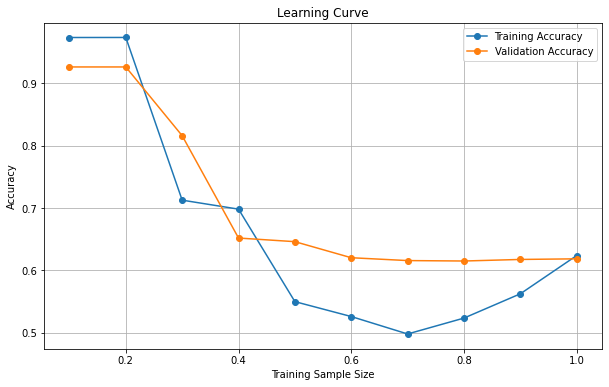

In [32]:
# 다양한 훈련 샘플 크기 설정
train_sizes = np.linspace(0.1, 1.0, 10)  # 10개의 다양한 훈련 크기

# 결과를 저장할 리스트 초기화
train_accuracy = []
val_accuracy = []

# 규제 강도 설정
C = 0.005  # 규제 강도. 값이 작을수록 규제가 강화됨. 조정 가능.

# 각 훈련 크기에 대해 모델 학습 및 평가
for train_size in train_sizes:
    # 훈련 크기에 맞게 데이터 샘플링
    num_samples = int(train_size * X_train_resampled.shape[0])
    X_train_subset = X_train_resampled[:num_samples]
    Y_train_subset = Y_train_resampled[:num_samples]
    
    # 모델 생성 및 학습
    model = LogisticRegression(C=C, penalty='l2')  # L2 규제 추가
    model.fit(X_train_subset, Y_train_subset)
    
    # 학습 데이터와 검증 데이터에 대한 정확도 계산
    train_pred = model.predict(X_train_subset)
    val_pred = model.predict(X_val)
    
    train_accuracy.append(accuracy_score(Y_train_subset, train_pred))
    val_accuracy.append(accuracy_score(Y_val, val_pred))

# 학습 곡선 그리기
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_accuracy, marker='o', label='Training Accuracy')
plt.plot(train_sizes, val_accuracy, marker='o', label='Validation Accuracy')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve'.format(C))
plt.legend()
plt.grid(True)
plt.show()

## 통계 모델 생성

In [12]:
# 독립 변수를 데이터프레임으로 변환
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=selected_features)

# CA_index와 TC_index 제거
X_train_resampled_df.drop(['CA_index', 'TC_index'], axis=1, inplace=True)

# 다항 로지스틱 회귀 모델 생성 (상수항 추가)
X_train_resampled_df = sm.add_constant(X_train_resampled_df)
model = sm.MNLogit(Y_train_resampled, X_train_resampled_df)

# 모델 피팅
result = model.fit()

Optimization terminated successfully.
         Current function value: 1.009336
         Iterations 10


### 교차검증
- data leakage 확인을 위해 교차검증 실행

In [13]:
# LogisticRegression 모델 생성
model = LogisticRegression()

# 교차 검증을 수행하고 정확도를 평가 지표로 사용
scoring = {'accuracy': 'accuracy'}
results = cross_validate(model, X_train_resampled_df, Y_train_resampled, cv=5, scoring=scoring)

# 각 교차 검증 결과 출력
for fold, accuracy in enumerate(results['test_accuracy'], 1):
    print(f"폴드 {fold} 정확도: {accuracy}")

# 평균 정확도 출력
print("평균 정확도:", results['test_accuracy'].mean())

폴드 1 정확도: 0.5952644674532467
폴드 2 정확도: 0.5957781523396741
폴드 3 정확도: 0.5950236776627338
폴드 4 정확도: 0.595216309495144
폴드 5 정확도: 0.5947507825668191
평균 정확도: 0.5952066779035236


In [14]:
cross_validation = pd.DataFrame({
    '폴드별정확도': results['test_accuracy'],
    '평균정확도': results['test_accuracy'].mean()
})
cross_validation

,폴드별정확도,평균정확도
0,0.595264,0.595207
1,0.595778,0.595207
2,0.595024,0.595207
3,0.595216,0.595207
4,0.594751,0.595207


- 다섯 개의 fold에서 모두 비슷한 정확도를 보이고 있으므로 data leakage의 증거가 없어보임.

### 정확도

In [15]:
# 테스트 데이터도 독립 변수를 데이터프레임으로 변환
X_test_df = pd.DataFrame(X_test, columns=selected_features)

# CA_index와 TC_index 제거
X_test_df.drop(['CA_index', 'TC_index'], axis=1, inplace=True)

# 상수항 추가
X_test_df = sm.add_constant(X_test_df)

# 모델로부터 예측을 얻습니다.
y_pred = result.predict(X_test_df)

# 가장 확률이 높은 클래스 선택
y_pred_classes = np.argmax(y_pred.values, axis=1)

# 실제 클래스와 예측 클래스 비교하여 정확도 계산
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(Y_test, y_pred_classes)
print("모델의 정확도:", accuracy)

모델의 정확도: 0.63075


### F1-score

In [16]:
# 모델로부터 예측을 얻습니다.
y_pred = result.predict(X_train_resampled_df)

# 다중 클래스 F1-Score 계산
from sklearn.metrics import f1_score

# 예측 클래스 선택 (가장 확률이 높은 클래스)
y_pred_classes = np.argmax(y_pred.values, axis=1)

# 실제 클래스와 예측 클래스로 F1-Score 계산
f1 = f1_score(Y_train_resampled, y_pred_classes, average='weighted')

print("Weighted F1-Score:", round(f1, 5))

Weighted F1-Score: 0.56866


### McFadden's Pseudo R^2

In [17]:
# 모델의 로그 우도 얻기
log_likelihood_model = result.llf

# Null 모델 (모든 예측 변수가 없는 모델)의 로그 우도 얻기
null_model = sm.MNLogit(Y_train_resampled, np.ones((len(Y_train_resampled), 1)))
result_null = null_model.fit()
log_likelihood_null = result_null.llf

# McFadden's Pseudo R-squared 계산
mcfaddens_r2 = 1 - (log_likelihood_model / log_likelihood_null)

print("McFadden's Pseudo R-squared:", round(mcfaddens_r2, 5))

Optimization terminated successfully.
         Current function value: 1.609438
         Iterations 1
McFadden's Pseudo R-squared: 0.37286


### pval

In [18]:
pval = pd.DataFrame(result.summary().tables[1].data)
pval = pval[pval[0] != 'const']
pval.columns = pval.iloc[0]
pval = pval[1:]
pval.to_csv('pval.csv')
pval

,JS_Price_Category=1,coef,std err,z,P>|z|,[0.025,0.975]
2,Population,-0.0418,0.007,-6.393,0.000,-0.055,-0.029
3,Crime_Rates,-0.1136,0.007,-17.465,0.000,-0.126,-0.101
4,YearMonth_encoded,0.9420,0.014,68.842,0.000,0.915,0.969
5,HSP_index,-0.0160,0.014,-1.157,0.247,-0.043,0.011
6,SDT_index,-0.1018,0.011,-9.413,0.000,-0.123,-0.081
7,IR,-0.1471,0.013,-11.724,0.000,-0.172,-0.123
8,UR,-0.0051,0.008,-0.666,0.506,-0.020,0.010
9,Floor,0.0202,0.007,3.020,0.003,0.007,0.033
10,JS_Price_Category=2,coef,std err,z,P>|z|,[0.025,0.975]
12,Population,-0.1233,0.007,-17.351,0.000,-0.137,-0.109


### 오즈비

In [19]:
# 회귀 모델 결과에서 coef 값을 추출합니다.
coef_values = result.params  # 이 코드는 모델 피팅 결과에서 계수를 추출합니다.

# 각 독립 변수의 오즈비 계산
odds_ratios = np.exp(coef_values).round(3)
odds_ratios.to_csv('OR.csv')
odds_ratios

,0,1,2,3
const,1.941,1.990,1.042,0.003
Population,0.959,0.884,1.123,0.055
Crime_Rates,0.893,0.770,0.340,0.045
YearMonth_encoded,2.565,4.970,18.641,104.855
HSP_index,0.984,0.798,0.557,0.445
SDT_index,0.903,0.678,1.187,0.006
IR,0.863,0.489,1.509,0.002
UR,0.995,0.655,0.749,0.026
Floor,1.020,1.093,0.483,4.283


### 99% 신뢰구간

In [20]:
# 각 계수에 대한 99% 신뢰 구간 출력
conf_intervals = result.conf_int(alpha=0.01).round(3)
conf_intervals.to_csv('CI.csv')
conf_intervals

lower  upper
JS_Price_Category                                
1                 const              0.642  0.684
                  Population        -0.059 -0.025
                  Crime_Rates       -0.130 -0.097
                  YearMonth_encoded  0.907  0.977
                  HSP_index         -0.052  0.020
                  SDT_index         -0.130 -0.074
                  IR                -0.179 -0.115
                  UR                -0.025  0.015
                  Floor              0.003  0.037
2                 const              0.667  0.709
                  Population        -0.142 -0.105
                  Crime_Rates       -0.280 -0.242
                  YearMonth_encoded  1.563  1.644
                  HSP_index         -0.264 -0.188
                  SDT_index         -0.419 -0.357
                  IR                -0.752 -0.677
                  UR                -0.445 -0.402
                  Floor              0.070  0.108
3                 const              0.015  0.067
                  Population         0.096  0.136
                  Crime_Rates       -1.108 -1.051
                  YearMonth_encoded  2.879  2.972
                  HSP_index         -0.627 -0.542
                  SDT_index          0.133  0.209
                  IR                 0.371  0.451
                  UR                -0.313 -0.266
                  Floor             -0.751 -0.703
4                 const             -5.897 -5.656
                  Population        -2.961 -2.856
                  Crime_Rates       -3.163 -3.046
                  YearMonth_encoded  4.549  4.756
                  HSP_index         -0.909 -0.711
                  SDT_index         -5.197 -4.999
                  IR                -6.506 -6.244
                  UR                -3.699 -3.563
                  Floor              1.413  1.497

- a=0.01일 때, p-value값을 고려하면 HSP_index, UR을 제외한다.

## 최종결론
- Features_Ranking의 상위 10가지를 제외한 나머지 변수에 대해 VIF와 Logistic Regression Analysis를 진행한다.
    - Logistit Regression의 p-value값의 제거요인인 UR, HSP_index
    - VIF의 제거요인인 CA_index, TC_index
    - 위의 네가지 요인(UR, HSP_index, TC_index, CA_index)을 변수에서 제거하여 머신러닝을 진행한다.